In [12]:
#Import the necessary libraries
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Specify the absolute path of your dataset
train_data_dir = 'original'
mask_data_dir = 'mask'
img_height, img_width, channels = 128, 128, 3
input_shape = (img_height, img_width, channels)
# Create a list to store the image and corresponding mask paths
image_paths = []
mask_paths = []
# Iterate through the dataset directory and add image and mask paths
for root, directories, files in os.walk(train_data_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))
            mask_paths.append(os.path.join(mask_data_dir, file))

# Create empty NumPy arrays for images and masks
images = np.zeros((len(image_paths), img_height, img_width, channels), dtype=np.float32)
masks = np.zeros((len(mask_paths), img_height, img_width, 1), dtype=bool)

In [3]:
# Iterate through the image and mask paths and load the data
for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    images[i] = img
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_width, img_height))
    mask = np.expand_dims(mask, axis=-1)
    mask = mask / 255.0
    masks[i] = mask

In [4]:
# Create the U-Net model for image segmentation
inputs = Input(input_shape)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

In [5]:
model = Model(inputs=inputs, outputs=conv10)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
# Train the model
model.fit(images, masks, batch_size=16, epochs=30, validation_split=0.1)
# Save the model
model.save('image_segmentation_model.keras')

Epoch 1/30
1/1 [==============================] - 13s 13s/step - loss: 0.6931 - accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 2/30
1/1 [==============================] - 8s 8s/step - loss: 0.6931 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - 8s 8s/step - loss: 0.6930 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 8s 8s/step - loss: 0.6930 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 8s 8s/step - loss: 0.6929 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 7s 7s/step - loss: 0.6929 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 8s 8s/step - loss: 0.6928 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 1.0000
Epoch 8/30
1/1 [=======================

(375, 500, 3)


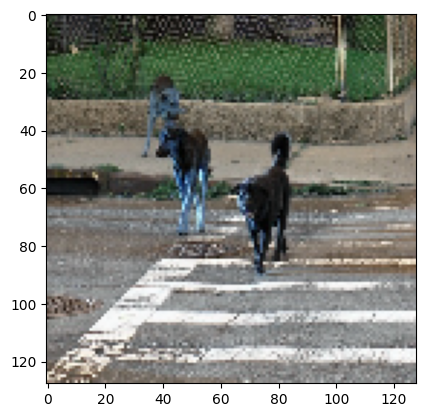

In [17]:
# Predict on an example image
example_image = cv2.imread('../dog1.jpg')
print(example_image.shape)
example_image = cv2.resize(example_image, (img_width, img_height))
example_image = example_image / 255.0
plt.imshow(example_image)
example_image = np.expand_dims(example_image, axis=0)

In [18]:
predicted_mask = model.predict(example_image)
print(predicted_mask.shape)
predicted_mask = np.squeeze(predicted_mask, axis=-1)
print(predicted_mask.shape)

1/1 [==============================] - 0s 458ms/step
(1, 128, 128, 1)
(1, 128, 128)


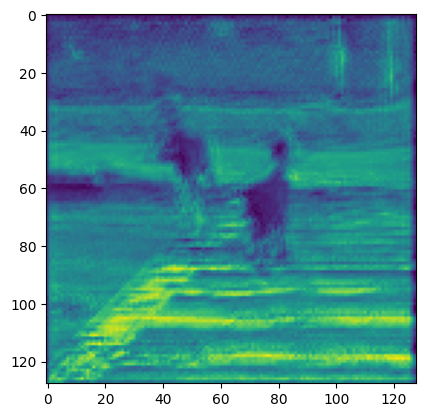

In [19]:
predicted_mask = predicted_mask.reshape(128,128,1)
plt.imshow(predicted_mask)

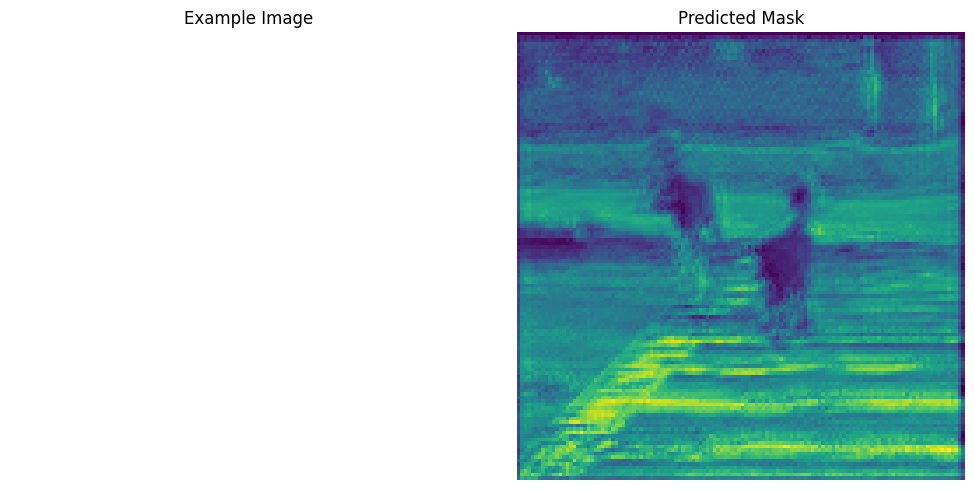

In [20]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2BGRA))
axes[0].set_title('Example Image')
axes[1].imshow(predicted_mask.reshape(128,128,1))
axes[1].set_title('Predicted Mask')
for ax in axes:
 ax.axis('off')
plt.tight_layout()
plt.show()